In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. LOAD THE DATA
data = pd.read_csv("date_alegeri_turul2.csv")  # Make sure your CSV has columns: varsta, sex, educatie, venit, vot
age = data['Varsta'].values
sex = data['Sex'].values
education = data['Educatie'].values
venit = data['Venit'].values
vote = data['Vot'].values  # 1 = candidate A, 0 = candidate B

# 2. BUILD THE FULL MODEL WITH ALL FOUR PREDICTORS
with pm.Model() as full_model:
    # Priors for coefficients
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    beta_age = pm.Normal("beta_age", mu=0, sigma=10)
    beta_sex = pm.Normal("beta_sex", mu=0, sigma=10)
    beta_edu = pm.Normal("beta_educatie", mu=0, sigma=10)
    beta_venit = pm.Normal("beta_venit", mu=0, sigma=10)

    # Linear combination
    mu = (intercept
          + beta_age * age
          + beta_sex * sex
          + beta_edu * education
          + beta_venit * venit)

    # Probability via logistic (sigmoid) function
    p = pm.Deterministic("p", pm.math.sigmoid(mu))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=vote)

    # 3. SAMPLE
    # We use few draws (10) and few tuning steps (10) just to see that code runs
    idata_full = pm.sample(draws=2000, tune=1000, chains=1, target_accept=0.9,
                           return_inferencedata=True, idata_kwargs={"log_likelihood": True})

# 4. SUMMARIZE POSTERIOR
print("\nSummary of the full model:")
display(az.summary(idata_full, var_names=["intercept", "beta_age", "beta_sex", "beta_educatie", "beta_venit"]))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [intercept, beta_age, beta_sex, beta_educatie, beta_venit]


In [2]:
# We'll look at the posterior means in absolute value as a naive measure of "influence"
# (In practice, you might consider credible intervals or standardized effects.)

summary_full = az.summary(
    idata_full,
    var_names=["beta_age", "beta_sex", "beta_educatie", "beta_venit"],
    kind="stats"
)

abs_means = summary_full["mean"].abs().sort_values(ascending=False)
top_2 = abs_means.head(2)
print("Posterior means (absolute) in descending order:\n", abs_means, "\n")
print("The two variables with the largest absolute posterior mean:\n", top_2.index.tolist())


Posterior means (absolute) in descending order:
 beta_sex         0.457
beta_educatie    0.251
beta_venit       0.143
beta_age         0.061
Name: mean, dtype: float64 

The two variables with the largest absolute posterior mean:
 ['beta_sex', 'beta_educatie']


In [8]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr

# Load the data
data = pd.read_csv("date_alegeri_turul2.csv")
X1 = data["Sex"].values
X2 = data["Educatie"].values
vote = data["Vot"].values

In [9]:
with pm.Model() as two_vars_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    beta_X1 = pm.Normal("beta_sex", mu=0, sigma=10)
    beta_X2 = pm.Normal("beta_educatie", mu=0, sigma=10)

    mu = intercept + beta_X1 * X1 + beta_X2 * X2
    p = pm.Deterministic("p", pm.math.sigmoid(mu))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=vote)

    idata_two = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9,
                          return_inferencedata=True, idata_kwargs={"log_likelihood": True})


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, beta_sex, beta_educatie]


Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 7 seconds.
C:\Users\Victus\AppData\Local\Temp\ipykernel_17640\3851313063.py:11: UserWarning: The number of samples is too small to check convergence reliably.
  idata_two = pm.sample(draws=10, tune=10, chains=2, target_accept=0.9,


In [10]:
# Summary of the two-variables model
print("\nSummary of the two-variables model:")
display(az.summary(idata_two, var_names=["intercept", "beta_sex", "beta_educatie"]))



Summary of the two-variables model:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.377,0.137,1.168,1.577,0.034,0.025,16.0,22.0,1.11
beta_sex,-0.926,0.122,-1.140,-0.775,0.025,0.018,24.0,22.0,1.23
beta_educatie,0.562,0.169,0.281,0.793,0.036,0.026,20.0,22.0,1.01


C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.23 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.23 for one or more samples. Yo

WAIC Comparison:
                 rank   elpd_waic      p_waic   elpd_diff        weight  \
two_vars_model     0  484.478599    2.413807    0.000000  1.000000e+00   
full_model         1  757.183921  107.303346  272.705322  1.188826e-44   

                       se        dse  warning     scale  
two_vars_model  25.012104   0.000000    False  deviance  
full_model      48.771585  35.245828     True  deviance  

LOO Comparison:
                 rank    elpd_loo      p_loo   elpd_diff        weight  \
two_vars_model     0  484.470502   2.409758    0.000000  1.000000e+00   
full_model         1  732.194088  94.808430  247.723586  1.051137e-38   

                       se        dse  warning     scale  
two_vars_model  26.654084   0.000000     True  deviance  
full_model      45.866501  30.063587     True  deviance  


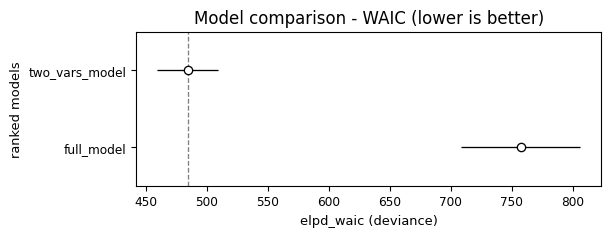

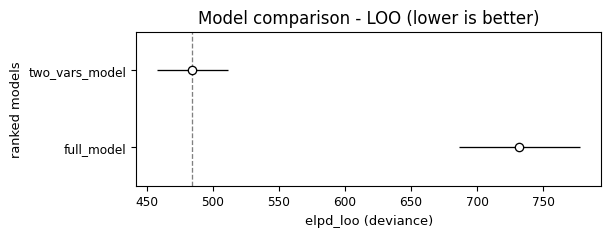

In [12]:
# COMPARE MODELS USING WAIC AND LOO
comparison_waic = az.compare(
    {"full_model": idata_full, "two_vars_model": idata_two},
    method="BB-pseudo-BMA",
    ic="waic",
    scale="deviance"
)
print("WAIC Comparison:\n", comparison_waic)

comparison_loo = az.compare(
    {"full_model": idata_full, "two_vars_model": idata_two},
    method="BB-pseudo-BMA",
    ic="loo",
    scale="deviance"
)
print("\nLOO Comparison:\n", comparison_loo)

# PLOT COMPARISON
az.plot_compare(comparison_waic)
plt.title("Model comparison - WAIC (lower is better)")
plt.show()

az.plot_compare(comparison_loo)
plt.title("Model comparison - LOO (lower is better)")
plt.show()
